**Проект Я.Практикум (Выпускной)**:
Отток клиентов в Ниединогоразрыва.ком

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

**Описание услуг**

Оператор предоставляет два основных типа услуг: 

1. Стационарную телефонную связь. Возможно подключение телефонного аппарата к нескольким линиям одновременно.
2. Интернет. Подключение может быть двух типов: через телефонную линию (DSL*,* от англ. *digital subscriber line*, «цифровая абонентская линия») или оптоволоконный кабель (*Fiber optic*).

Дополнительные услуги:

- Интернет-безопасность: антивирус (*DeviceProtection*) и блокировка небезопасных сайтов (*OnlineSecurity*);
- Выделенная линия технической поддержки (*TechSupport*);
- Облачное хранилище файлов для резервного копирования данных (*OnlineBackup*);
- Стриминговое телевидение (*StreamingTV*) и каталог фильмов (*StreamingMovies*).

**Описание данных**

Данные состоят из файлов, полученных из разных источников:

- `contract_new.csv` — информация о договоре;
- `personal_new.csv` — персональные данные клиента;
- `internet_new.csv` — информация об интернет-услугах;
- `phone_new.csv` — информация об услугах телефонии.

Во всех файлах столбец `customerID` содержит код клиента.

**Цель** - Построить модель машинного обучения для прогнозирования оттока клиентов.

**План работы**
- Подготовка данных;
- Исследование данных;
- Работа с моделями и подбор параметров;
- Выбор итоговой модели и вывод.

In [2]:
pip install phik

     |████████████████████████████████| 679 kB 1.2 MB/s eta 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

import phik
from phik.report import plot_correlation_matrix
from phik import report

from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix

from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.dummy import DummyClassifier

from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

from catboost import CatBoostClassifier, Pool, cv

pd.options.mode.chained_assignment = None

**Подготовка данных**

In [5]:
try:
    contract = pd.read_csv('contract.csv')
    internet = pd.read_csv('internet.csv')
    personal = pd.read_csv('personal.csv')
    phone = pd.read_csv('phone.csv')
except:
    contract = pd.read_csv('/datasets/final_provider/contract.csv')
    internet = pd.read_csv('/datasets/final_provider/internet.csv')
    personal = pd.read_csv('/datasets/final_provider/personal.csv')
    phone = pd.read_csv('/datasets/final_provider/phone.csv')
#     contract = pd.read_csv('../datasets/final_provider/contract.csv')
#     internet = pd.read_csv('../datasets/final_provider/internet.csv')
#     personal = pd.read_csv('../datasets/final_provider/personal.csv')
#     phone = pd.read_csv('../datasets/final_provider/phone.csv')

In [3]:
contract.sample(5)

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
6961,8155-IBNHG,2017-12-01,2019-12-01 00:00:00,Month-to-month,Yes,Credit card (automatic),75.40,1747.85
3818,8819-ZBYNA,2015-04-01,No,Two year,Yes,Credit card (automatic),109.10,6393.65
6650,5850-BDWCY,2019-08-01,No,Month-to-month,No,Mailed check,20.20,123.65
4172,1905-OEILC,2020-01-01,No,Month-to-month,No,Mailed check,19.50,19.5
3698,7346-MEDWM,2015-03-01,No,Month-to-month,Yes,Electronic check,83.25,4949.1


In [4]:
internet.sample(5)

,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
3091,5915-ANOEI,DSL,Yes,Yes,Yes,Yes,Yes,No
1282,6022-KOUQO,DSL,No,No,No,Yes,No,No
651,3551-GAEGL,DSL,Yes,No,No,No,No,No
3380,0958-YHXGP,Fiber optic,No,No,No,No,No,No
2529,3665-JATSN,DSL,No,Yes,No,No,No,Yes


In [5]:
personal.sample(5)

,customerID,gender,SeniorCitizen,Partner,Dependents
6981,5568-DMXZS,Female,0,No,No
2885,7923-IYJWY,Male,1,No,No
565,5846-NEQVZ,Male,0,Yes,Yes
4925,5966-EMAZU,Male,0,Yes,No
6928,5306-BVTKJ,Male,0,Yes,Yes


In [6]:
phone.sample(5)

,customerID,MultipleLines
5840,4609-KNNWG,No
3625,7130-CTCUS,No
76,9919-YLNNG,No
4485,3898-GUYTS,Yes
2931,5519-NPHVG,Yes


соберём все данные вместе и посмотрим, что получится

In [6]:
df = contract.merge(personal, how='left', on='customerID').\
merge(internet, how='left', on='customerID').\
merge(phone, how='left', on='customerID')
df = df.set_index('customerID')
df.sample(5)

,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
customerID,,,,,,,,,,,,,,,,,,,
6374-NTQLP,2014-02-01,No,Two year,Yes,Credit card (automatic),104.10,7447.7,Male,1,Yes,Yes,Fiber optic,Yes,No,Yes,Yes,Yes,Yes,No
3722-WPXTK,2019-11-01,2019-12-01 00:00:00,Month-to-month,Yes,Electronic check,88.35,88.35,Male,0,No,No,Fiber optic,No,No,No,No,Yes,Yes,No
1035-IPQPU,2014-11-01,No,Month-to-month,Yes,Electronic check,103.50,6479.4,Female,1,Yes,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,Yes
6490-FGZAT,2019-08-01,No,Month-to-month,No,Mailed check,20.65,109.3,Male,0,No,No,NaN,NaN,NaN,NaN,NaN,NaN,NaN,No
2003-CKLOR,2014-05-01,2019-11-01 00:00:00,Month-to-month,No,Electronic check,99.50,6710.5,Male,0,No,No,Fiber optic,No,Yes,Yes,No,Yes,Yes,No


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 7043 entries, 7590-VHVEG to 3186-AJIEK
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   BeginDate         7043 non-null   object 
 1   EndDate           7043 non-null   object 
 2   Type              7043 non-null   object 
 3   PaperlessBilling  7043 non-null   object 
 4   PaymentMethod     7043 non-null   object 
 5   MonthlyCharges    7043 non-null   float64
 6   TotalCharges      7043 non-null   object 
 7   gender            7043 non-null   object 
 8   SeniorCitizen     7043 non-null   int64  
 9   Partner           7043 non-null   object 
 10  Dependents        7043 non-null   object 
 11  InternetService   5517 non-null   object 
 12  OnlineSecurity    5517 non-null   object 
 13  OnlineBackup      5517 non-null   object 
 14  DeviceProtection  5517 non-null   object 
 15  TechSupport       5517 non-null   object 
 16  StreamingTV       5517 non-null 

Переименуем колонку gender

In [7]:
df = df.rename(columns={'gender':'Gender'})

Вероятнее всего, пропуски указывают на отсутствие предоставляемых услуг, поэтому мы можем безопасно пометить их как No.

Для поля InternetService необходимо указать тип подключения. Добавим еще одно значение, которое будет обозначать неопределенные данные - Undefined.

Клиенты, которые пользовались услугами менее месяца, еще не успели оплатить ничего. Поэтому мы присвоим им в поле TotalCharges общие отчисления, равные нулю.

In [8]:
df['InternetService'] = df['InternetService'].fillna('Undefined')

null_columns = [
    'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 
    'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines'
]
df[null_columns] = df[null_columns].fillna('No')

df['TotalCharges'] = df['TotalCharges'].fillna(0)
df["TotalCharges"] = df["TotalCharges"].replace(" ", 0)

Сохраним целевой признак до преобразования дат

In [9]:
df['Result'] = (df['EndDate'] != 'No').astype('int')

Преобразуем типы дат, чтобы получить нужную нам информацию

In [10]:
df.loc[(df['EndDate'] == 'No'), 'EndDate'] = '2020-02-01'
df['EndDate'] = pd.to_datetime(df['EndDate'])
df['BeginDate'] = pd.to_datetime(df['BeginDate'])

Рассчитаем количество дней пользования услугами

In [11]:
df['UsingServiceDays'] = (df['EndDate'] - df['BeginDate']).dt.days
df['UsingServiceDays'] = df['UsingServiceDays'].astype('int')

Преобразуем TotalCharges во float

In [12]:
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'])

Столбцы BeginDate и EndDate содержат данные о датах и не могут быть использованы в модели линейной регрессии. В этой связи их целесообразно исключить из датафрейма.

In [13]:
del df['BeginDate'], df['EndDate']

Преобразуем признаки пола

In [14]:
df['Gender'] = (df['Gender'] == 'Male').astype('int')

Посмотрим остальные словарные значения, чтобы понимать, что к ним применять

In [17]:
df['PaymentMethod'].value_counts()

Electronic check             2365
Mailed check                 1612
Bank transfer (automatic)    1544
Credit card (automatic)      1522
Name: PaymentMethod, dtype: int64

In [18]:
df['InternetService'].value_counts()

Fiber optic    3096
DSL            2421
Undefined      1526
Name: InternetService, dtype: int64

In [19]:
df['Type'].value_counts()

Month-to-month    3875
Two year          1695
One year          1473
Name: Type, dtype: int64

Так как признаки не масштабируются и количество уникальных значений внутри каждого признака не слишком велико, мы будем использовать One-Hot Encoding (OHE).

Мы подготовим наборы признаков для One-Hot Encoding преобразования и масштабирования, а также выделим целевой признак от остальных. Преобразования будут выполнены после проведения исследовательского анализа данных.

In [15]:
ohe_names = ['PaymentMethod', 'InternetService', 'Type']
numeric_names = ["TotalCharges", "MonthlyCharges", "UsingServiceDays"]
target_name = 'Result'
features_names = list(df.columns)
features_names.remove(target_name)
categories = [x for x in features_names if x not in numeric_names]

Вывод:
- Были обработаны пропуски
- Изненены типы данных для временных признаков
- Выделен целевой признак, предопределены нецелевые категориальные и численные признаки
- Преобразованы все значения вида Yes-No в числа

**Исследовательский анализ**

Проверим баланс классов

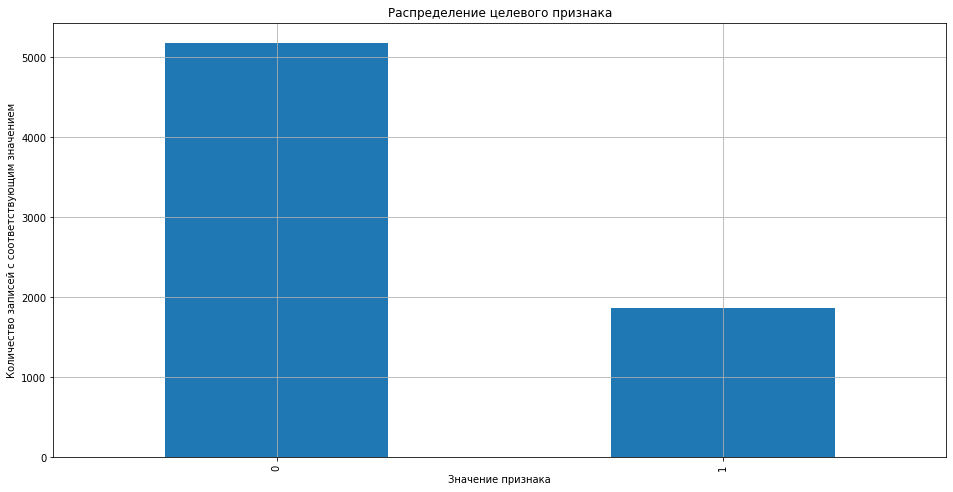

In [16]:
df_target = df[target_name]
fig, ax = plt.subplots(1)
ax.set_title('Распределение целевого признака')
ax.set_xlabel('Значение признака')
ax.set_ylabel('Количество записей с соответствующим значением')
df_target.value_counts().plot(kind='bar', figsize=(16,8), ax=ax, grid = True);

В данных наблюдается явный дисбаланс классов в пользу значения, которое нам нужно предсказать

<div class="alert alert-block alert-success"; style="border-left: 6px solid green">
<b>Успех ✔️</b>
       
Дисбаланс зафиксирован!
    
</div>


Посмотрим распределение нецелевых признаков

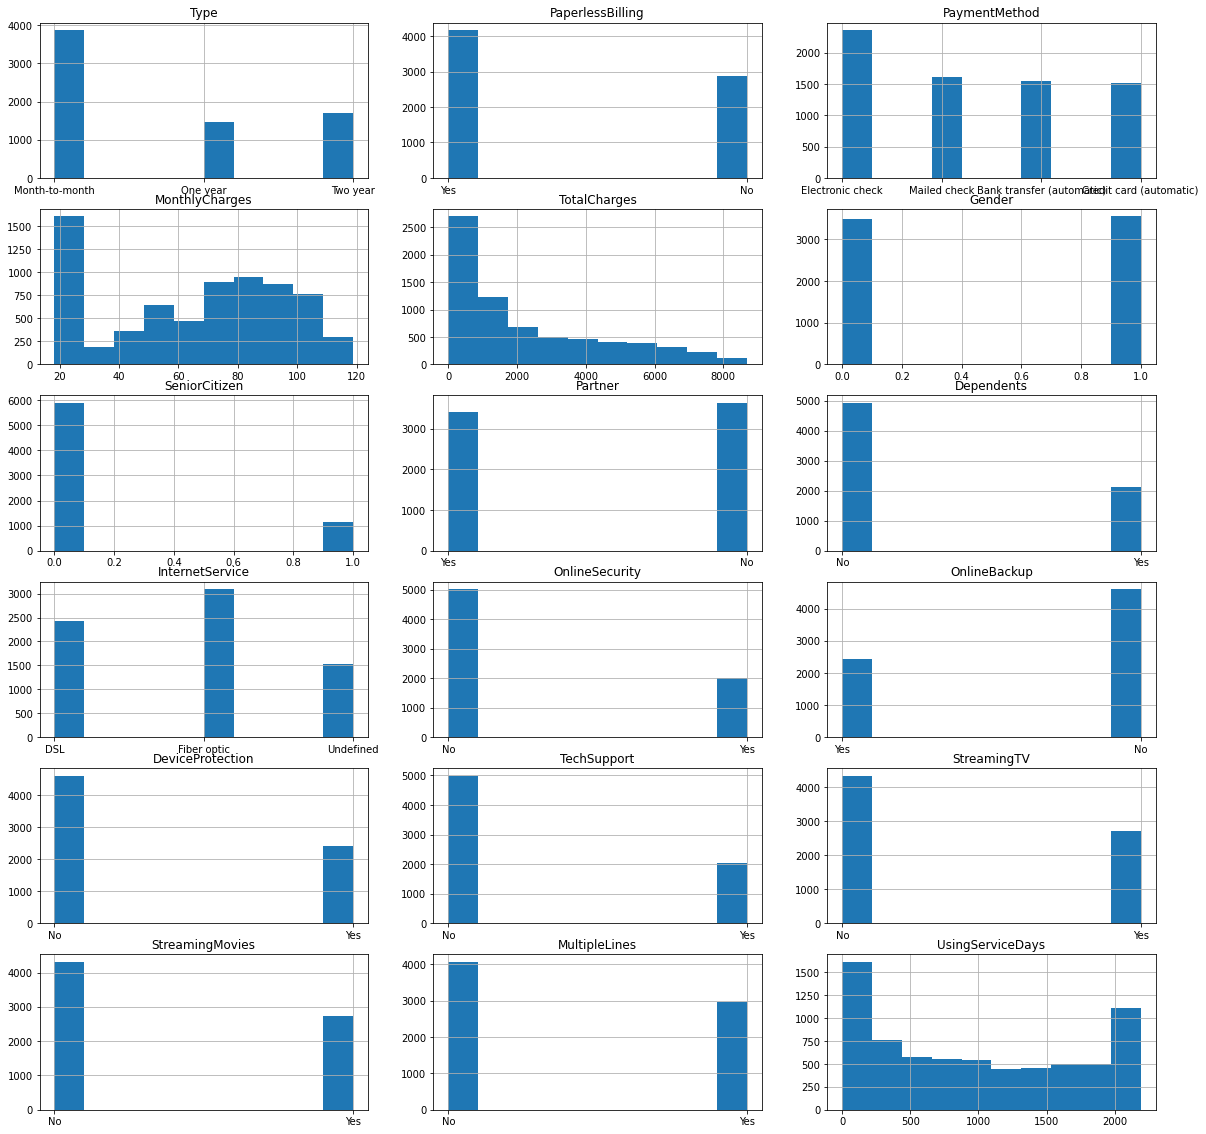

In [17]:
ncols = 3
nrows = math.ceil(len(features_names) / ncols)

plt.figure(figsize=(20, 20))

counter = 0
for feature in features_names:
    counter += 1
    plt.subplot(nrows, ncols, counter)
    plt.hist(df[feature])
    plt.title(feature)
    plt.grid()

Видно, что дополнительные услуги не пользуются популярностью, а те, кто их выбирают, часто выбирают одни и те же услуги.

Также стоит обратить внимание на распределения общих расходов и длительности пользования услугами, потому что клиенты, выбирающие более дорогие тарифы, скорее всего, остаются на более длительный срок.

Посмотрим на распределение относительно нашего целевого признака

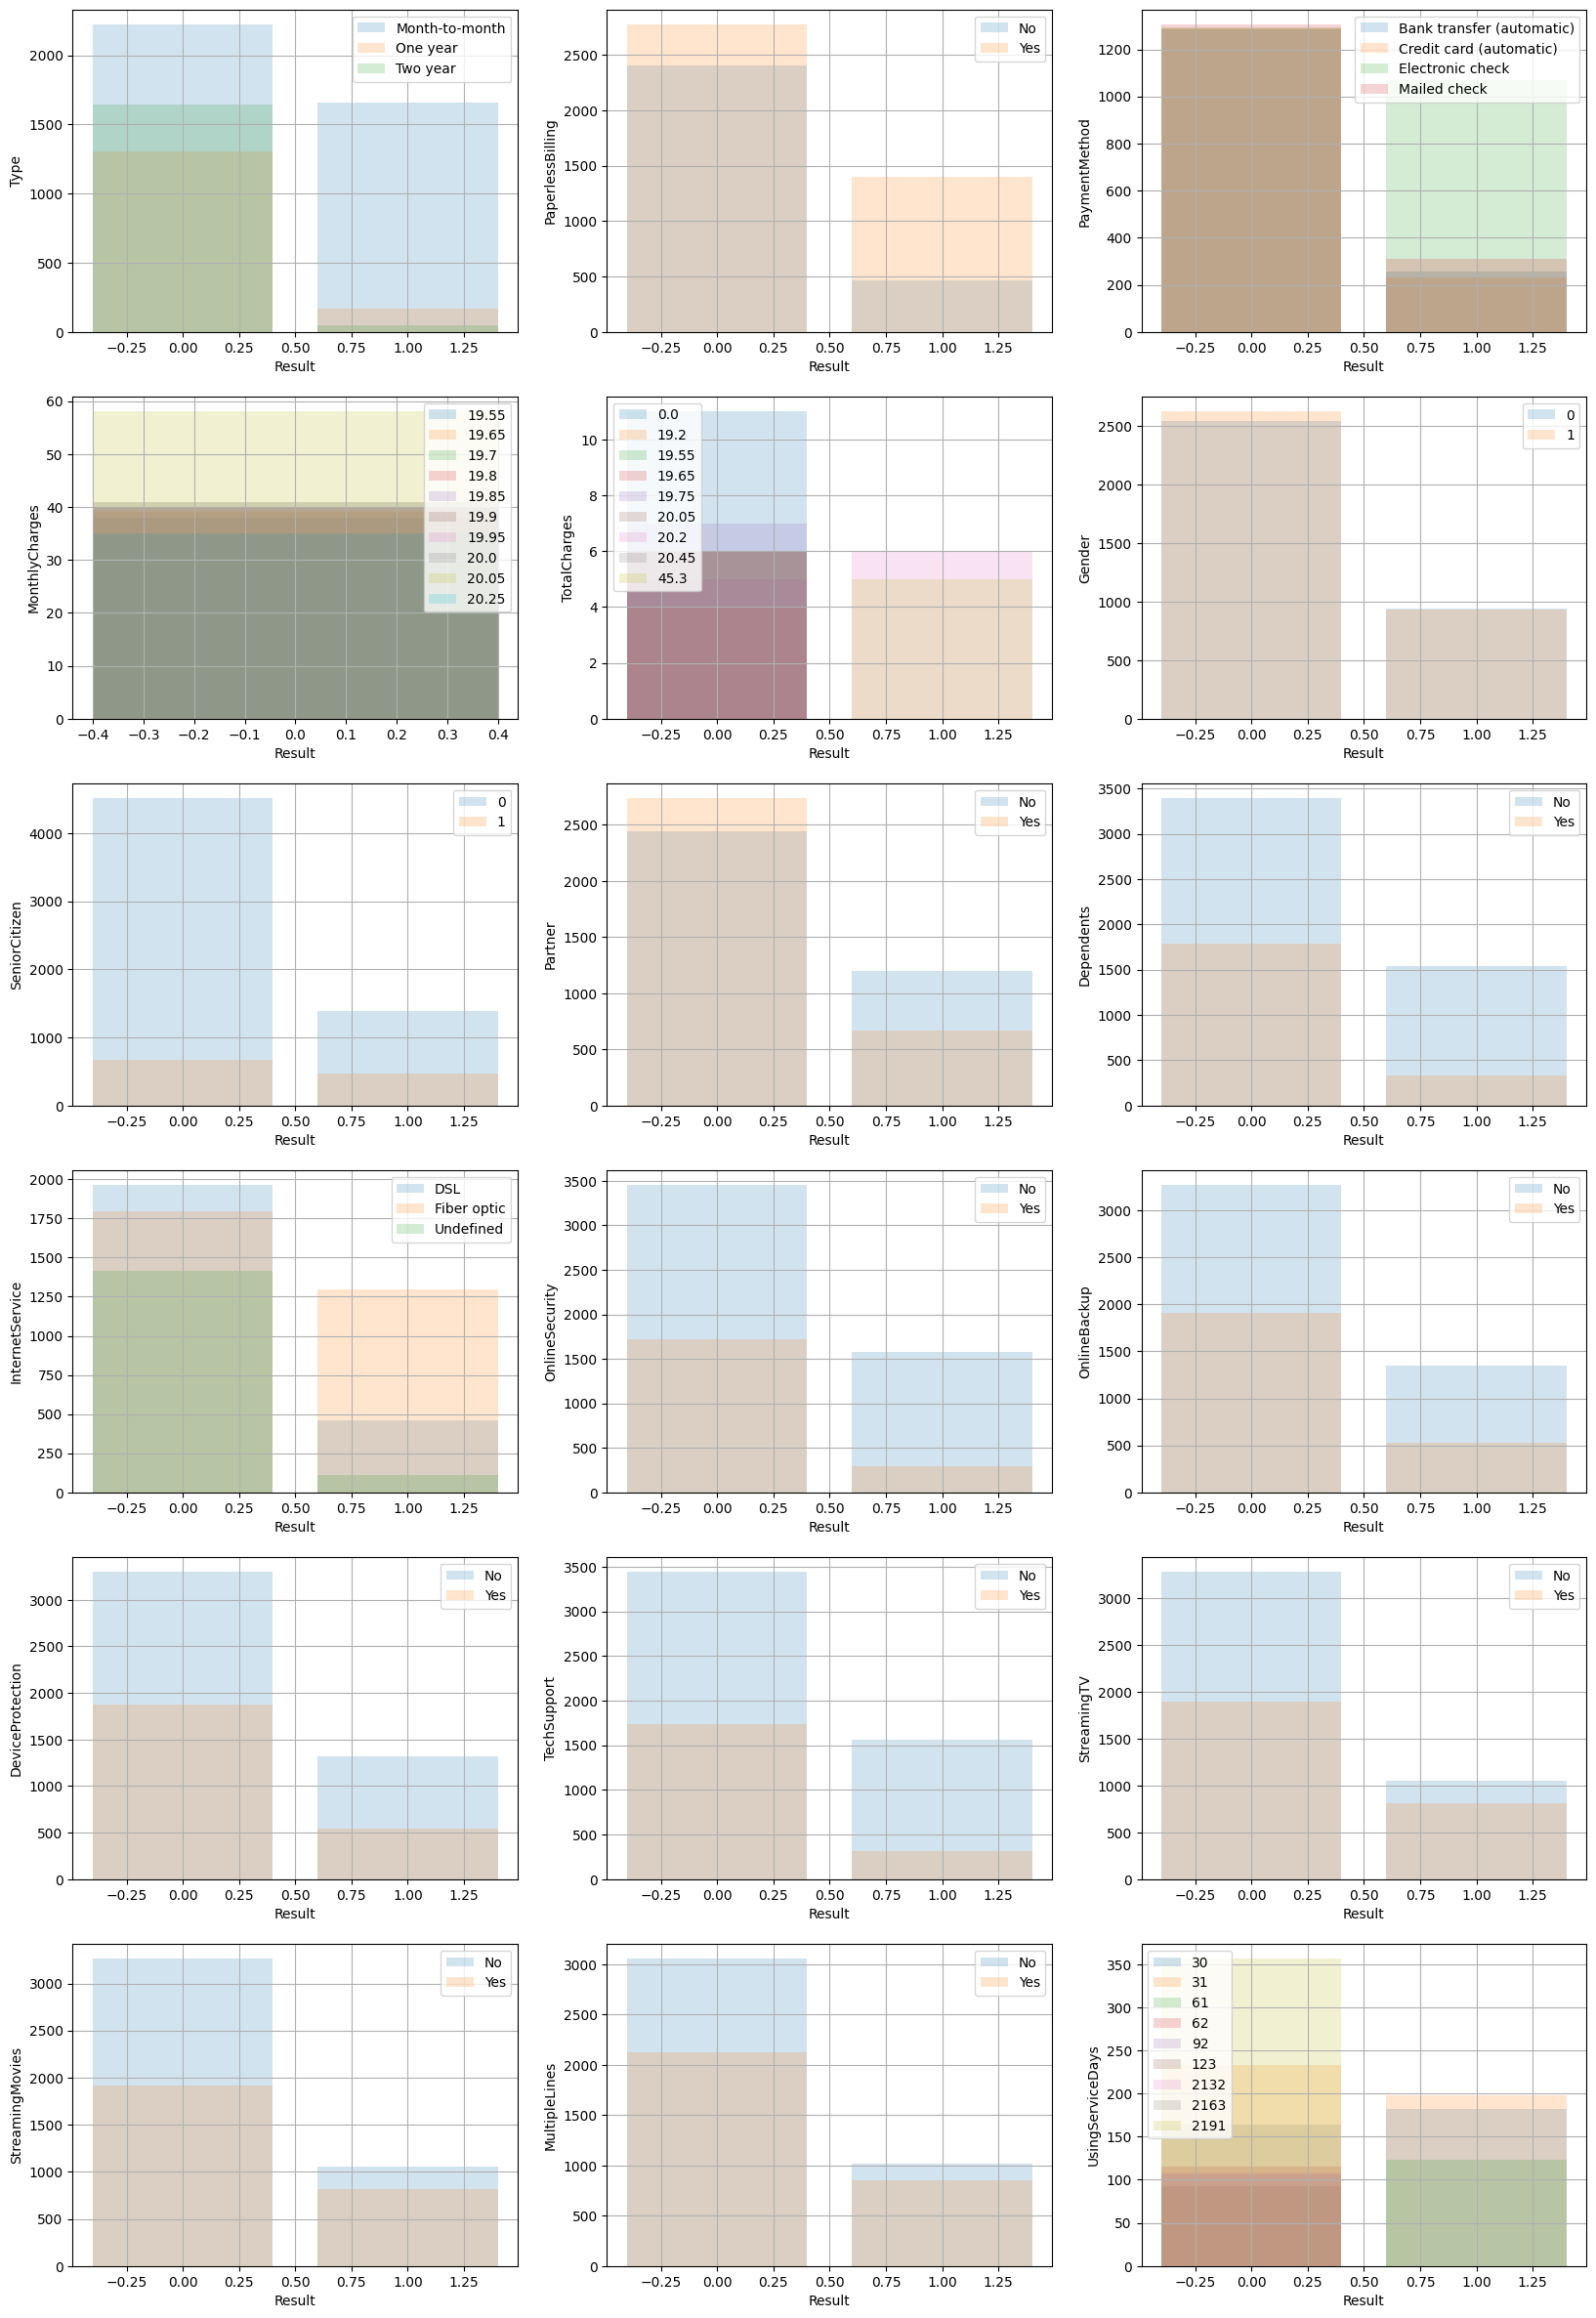

In [23]:
plt.figure(figsize=(20, 30))

counter = 0
for feature in features_names:
    counter += 1
    feature_values = set(df[feature])
    
    if len(feature_values) > 10:
        feature_values = df[feature].value_counts().index[:10]
    
    ax = plt.subplot(nrows, ncols, counter)

    df_tmp = df.groupby([feature, target_name])[target_name].count().nlargest(10)
    df_tmp = df_tmp.unstack()

    for column in df_tmp.T.columns:
        ax.bar(df_tmp.T.index, df_tmp.T[column], alpha=0.2, label = column)

    plt.xlabel(target_name)
    plt.ylabel(feature)
    plt.legend()
    plt.grid()

У клиентов, выбирающих ежемесячную оплату, доля отказов примерно одинаковая, в то время как у клиентов, выбирающих оплату за год или два, доля отказов минимальная.

Наибольшее количество отказов связано с использованием услуг до двух месяцев, при этом с увеличением времени пользования количество отказов снижается.

Клиенты, не пользующиеся интернетом, имеют наименьшую долю отказов, а на втором месте по количеству отказов находятся клиенты с подключением DSL

Посмотрим выбросы и диаграмму размаха

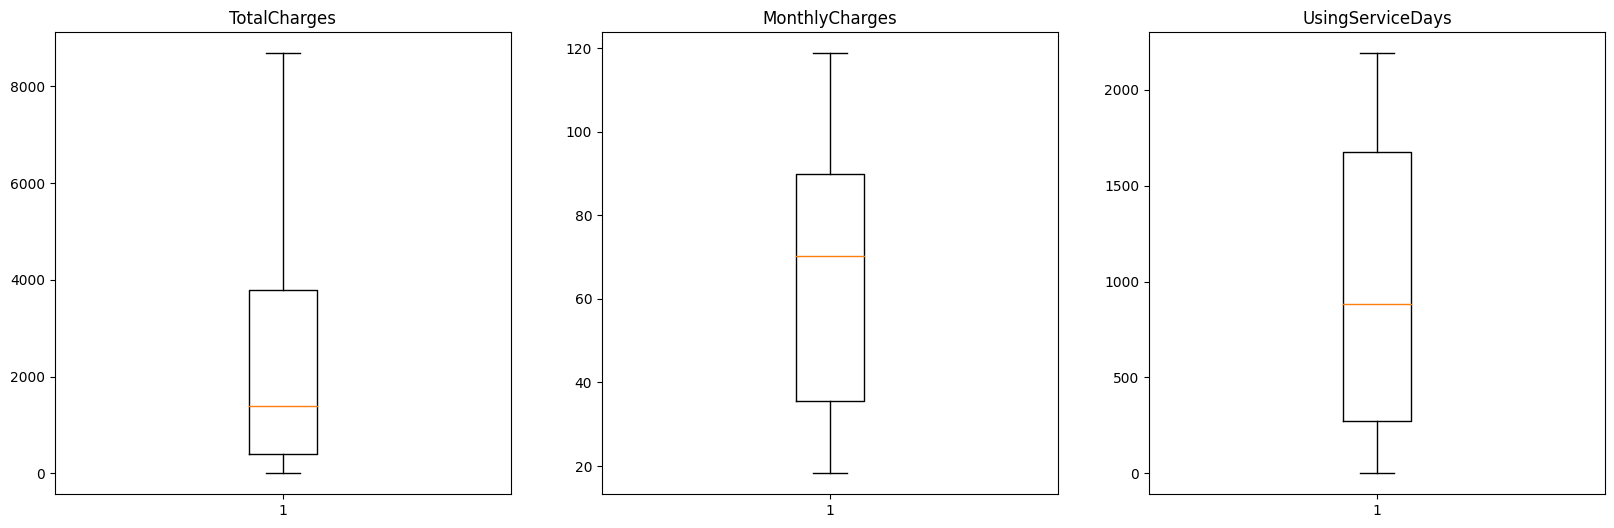

In [24]:
plt.figure(figsize=(20, 6))

counter = 0
numeric_len = len(numeric_names)
for feature in numeric_names:
    counter += 1
    plt.subplot(1, numeric_len, counter)
    plt.boxplot(df[feature])
    plt.title(feature)

**Вывод**:
Данные распределены довольно равномерно и не нуждаются в значительной обработке.
Были проанализированы графики: распределения целевого признака, диаграммы размаха численных признаков, распределение нецелевых признаков, также распределение этих признаков относительного целевого

**Подготовка данных для моделей**

Оценим значимость признаков, посмотрим матрицу корреляции

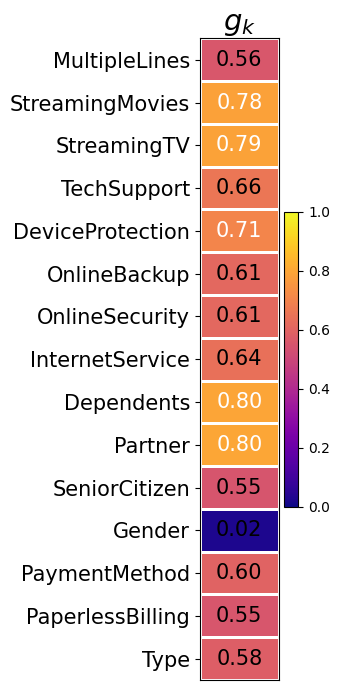

In [27]:
global_correlation, global_labels = df[categories].global_phik(interval_cols = ['MonthlyCharges', 'TotalCharges', 'UsingServiceDays'])

plot_correlation_matrix(global_correlation, 
                        x_labels=[''], y_labels=global_labels, 
                        vmin=0, vmax=1, figsize=(3.5,7),
                        color_map="plasma", title=r"$g_k$",
                        fontsize_factor=1.5);
plt.tight_layout();

In [28]:
phik_overview = df.phik_matrix()

interval columns not set, guessing: ['MonthlyCharges', 'TotalCharges', 'Gender', 'SeniorCitizen', 'Result', 'UsingServiceDays']


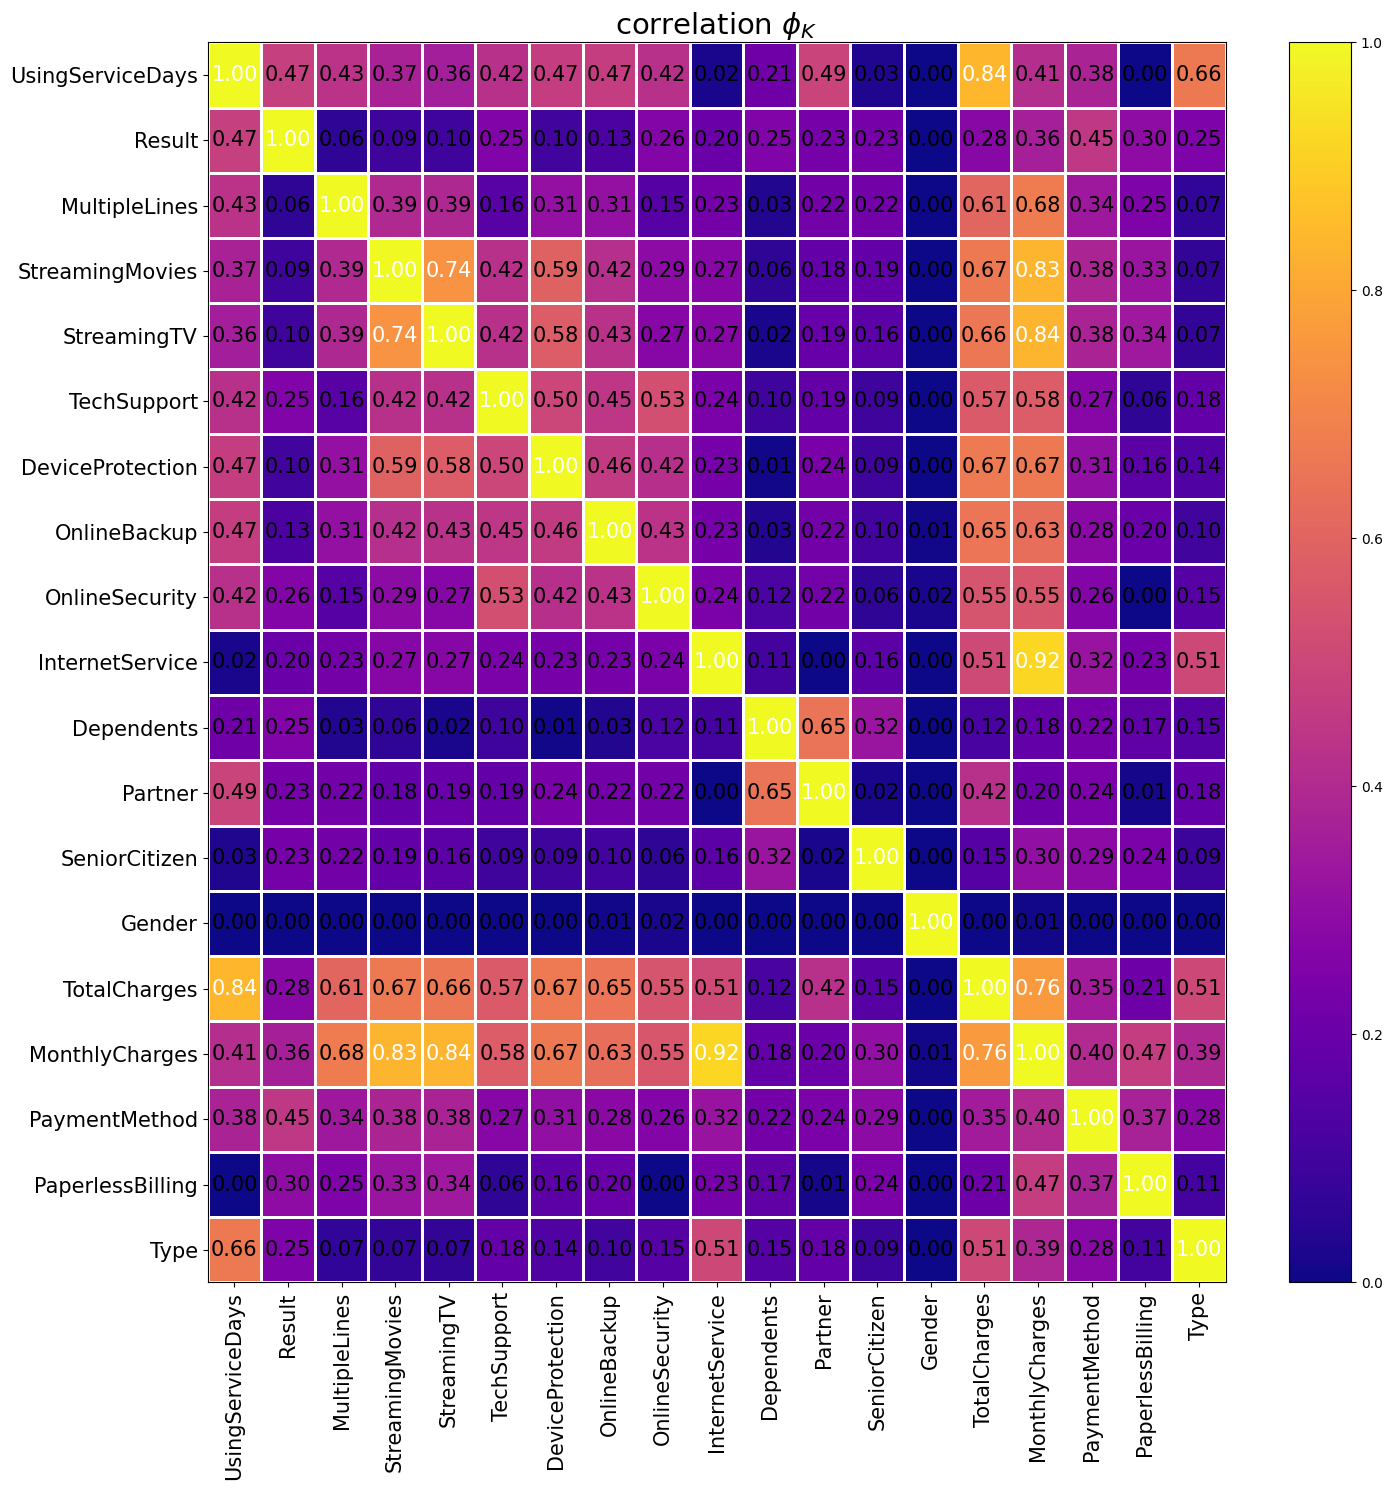

In [29]:
plot_correlation_matrix(phik_overview.values, 
                        x_labels=phik_overview.columns, 
                        y_labels=phik_overview.index, 
                        vmin=0, vmax=1, color_map="plasma", 
                        title=r"correlation $\phi_K$", 
                        fontsize_factor=1.5, 
                        figsize=(15, 15))
plt.tight_layout()

Наиболее значимыми признаками являются количество дней использования и общая сумма платежей. При этом, размер ежемесячных платежей имеет отрицательную корреляцию с целевым показателем.

Воспользуемся CatBoost, чтобы оценить значение признаков.

In [18]:
RANDOM_STATE = 220523 

In [19]:
df_features = df[features_names]
df_target = df[target_name]

features_train, features_test, target_train, target_test = train_test_split(df_features, df_target, test_size=0.25, random_state=RANDOM_STATE)

train_pool = Pool(data=features_train, label=target_train, cat_features=categories, feature_names=features_names)
v_counts = target_train.value_counts()
scale_pos_weight = v_counts[0] / v_counts[1]

In [20]:
catboost = CatBoostClassifier(verbose=0, task_type="CPU",  random_seed=RANDOM_STATE, thread_count=-1, scale_pos_weight=scale_pos_weight)
catboost.fit(train_pool)

Получим значимые признаки

In [21]:
features_and_score = list(zip(catboost.feature_names_, catboost.get_feature_importance()))
df_score = pd.DataFrame(features_and_score)
df_score.sort_values(by=1, ascending=False)

,0,1
17,UsingServiceDays,39.991291
0,Type,13.464859
9,InternetService,8.604207
4,TotalCharges,8.245030
3,MonthlyCharges,7.830526
2,PaymentMethod,5.785910
1,PaperlessBilling,2.276948
15,StreamingMovies,1.979690
16,MultipleLines,1.706323
14,StreamingTV,1.559030


Некоторые признаки не оказывают существенного влияния на итоговый результат. Поэтому уменьшение размерности набора признаков должно быть безопасным решением.

In [22]:
df_score.columns = ['feature_name', 'score']
features_choosen = list(df_score.query('score > 0.3')['feature_name'])
features_choosen

['Type',
 'PaperlessBilling',
 'PaymentMethod',
 'MonthlyCharges',
 'TotalCharges',
 'Gender',
 'SeniorCitizen',
 'Partner',
 'Dependents',
 'InternetService',
 'OnlineSecurity',
 'OnlineBackup',
 'DeviceProtection',
 'TechSupport',
 'StreamingTV',
 'StreamingMovies',
 'MultipleLines',
 'UsingServiceDays']

In [23]:
features_train_linear = features_train[features_choosen]
features_test_linear = features_test[features_choosen] 

features_train = features_train[features_choosen]
features_test = features_test[features_choosen] 

In [24]:
ohe_names = ['PaymentMethod', 'InternetService', 'Type']
numeric_names = ["TotalCharges", "MonthlyCharges", "UsingServiceDays"]
target_name = 'Result'
features_names = list(df.columns)
features_names.remove(target_name)
categories = [x for x in features_names if x not in numeric_names and x in features_choosen]

In [25]:
ohe = OneHotEncoder(drop = 'first', handle_unknown = 'error')
ohe.fit(features_train[categories])
new_categories = ohe.get_feature_names(categories)

In [26]:
features_train_ohe = pd.DataFrame(ohe.transform(features_train[categories]).toarray(),
                                               columns = new_categories, index = features_train.index)
features_train_ohe = features_train_ohe.join(features_train[numeric_names])
features_test_ohe = pd.DataFrame(ohe.transform(features_test[categories]).toarray(),
                                               columns = new_categories, index = features_test.index)
features_test_ohe = features_test_ohe.join(features_test[numeric_names])

In [27]:
features_train_linear_ohe = pd.DataFrame(ohe.transform(features_train_linear[categories]).toarray(),
                                               columns = new_categories, index = features_train_linear.index)
features_train_linear_ohe = features_train_linear_ohe.join(features_train_linear[numeric_names])
features_test_linear_ohe = pd.DataFrame(ohe.transform(features_test_linear[categories]).toarray(),
                                               columns = new_categories, index = features_test_linear.index)
features_test_linear_ohe = features_test_linear_ohe.join(features_test_linear[numeric_names])

In [28]:
features_train_ohe = features_train_ohe.round().astype(int)

Проведем скалирование числовых признаков для линейной модели

In [29]:
scaler = StandardScaler()
scaler.fit(features_train_linear_ohe[numeric_names])

features_train_linear_ohe[numeric_names] = scaler.transform(features_train_linear_ohe[numeric_names])
features_test_linear_ohe[numeric_names] = scaler.transform(features_test_linear_ohe[numeric_names])

features_train_linear_ohe[numeric_names].sample(5, random_state=RANDOM_STATE)

,TotalCharges,MonthlyCharges,UsingServiceDays
customerID,,,
3569-JFODW,1.916862,0.869221,1.595416
1383-EZRWL,-0.944407,-1.486389,-1.052020
8350-NYMVI,-0.312755,-0.787015,0.250942
2391-IPLOP,0.501002,0.161541,0.700886
5276-KQWHG,-0.959050,0.159880,-1.256905


Вывод:
- Первостепенно был решен вопрос важности признаков, рассмотрена тепловая карта
- Выявлены признаки, влияющие на формирования целевого признака
- Категориальные признаки были закодированы с помощью 'OneHotEncoder'
- Численные признаки скалировались для линейной модели

**Обучение моделей**

Логистическая регрессия

In [48]:
param_grid = {'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000] }
model = LogisticRegression(solver='newton-cg', penalty='l2', class_weight = 'balanced', random_state=RANDOM_STATE)
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_train_linear_ohe, target_train)
grid.best_params_

{'C': 100}

In [49]:
grid.best_score_

0.8459522906450619

Случайный лес

In [50]:
param_grid = {
    'max_depth': [2, 10, 20, 30, 40],
    'min_samples_split': range(2, 11, 2),
    'min_samples_leaf': range(2, 11, 2),
    'n_estimators': range(50, 101, 10)
}

model = RandomForestClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')

grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_train_ohe, target_train)
grid.best_params_

{'max_depth': 10,
 'min_samples_leaf': 8,
 'min_samples_split': 2,
 'n_estimators': 100}

In [51]:
grid.best_score_

0.8578758018026443

Дерево решений

In [52]:
param_grid = {
    "criterion":["gini", "entropy"],
    "max_depth": (2, 41, 2),
    "min_samples_split": range(2, 21, 2),
    "min_samples_leaf": range(2, 11, 2)
}

model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')
grid = GridSearchCV(model, param_grid, cv=5, scoring='roc_auc')
grid.fit(features_train_ohe, target_train)
grid.best_params_

{'criterion': 'gini',
 'max_depth': 41,
 'min_samples_leaf': 10,
 'min_samples_split': 2}

In [53]:
grid.best_score_

0.8143707618146987

CatBoost

In [58]:
param_grid = {
    'iterations':[100, 500],
    'learning_rate': [0.1],
    'depth': range(8, 11, 2), 
#     'l2_leaf_reg': range(3, 6, 2),
    'border_count':[128],
}

model = CatBoostClassifier(loss_function='Logloss', auto_class_weights = 'Balanced', silent=True, eval_metric='AUC', task_type="GPU", devices='0:4', random_seed=RANDOM_STATE, thread_count=-1)
grid = GridSearchCV(model, param_grid,  cv=5, scoring='roc_auc')
grid.fit(features_train_ohe, target_train)
grid.best_params_

Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric period is 5 because AUC is/are not implemented for GPU
Default metric perio

{'border_count': 128, 'depth': 10, 'iterations': 500, 'learning_rate': 0.1}

In [59]:
grid.best_score_

0.9137183875687871

Вывод:
- Обучены и проверены по целевой метрике auc четыре модели машинного обучения.
- Лучший показатель показала модель CatBoost.

**Тест модели**

In [60]:
def make_roc_curve(target_test, predicted_test):
    fpr, tpr, thresholds = roc_curve(target_test, predicted_test)

    plt.figure()
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC-кривая')
    plt.show()

In [30]:
model = CatBoostClassifier(loss_function='Logloss', auto_class_weights = 'Balanced', depth=10, eval_metric='AUC', iterations=500, learning_rate=0.1,  random_seed=RANDOM_STATE, thread_count=-1, border_count=128, verbose=0)
model.fit(X = features_train_ohe, y = target_train)

In [31]:
predicted_test = model.predict_proba(features_test_ohe)[:,1]
roc_auc_score(target_test, predicted_test)

0.8827165893914211

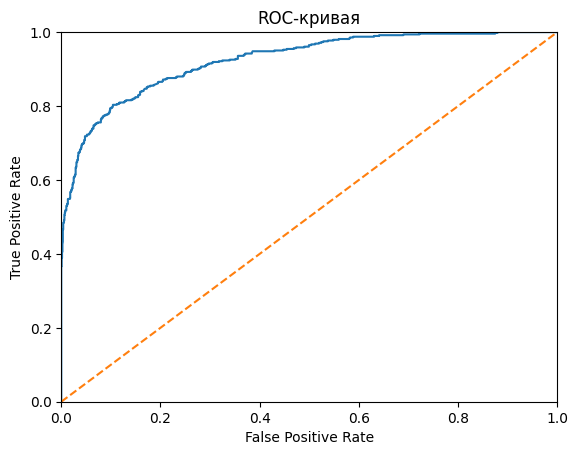

In [63]:
make_roc_curve(target_test, predicted_test)

Проверка на адекватность

In [64]:
dummy_clf = DummyClassifier(strategy="constant", constant=1)
dummy_clf.fit(features_train_ohe, target_train)
predicted = dummy_clf.predict_proba(features_test_ohe)[:, 1]
roc_auc_score(target_test, predicted)

0.5

Модель сумела заметно превысить ожидаемый порог целевой метрики, показав результат 0.88

In [32]:
features_and_score = list(zip(model.feature_names_, model.get_feature_importance()))
df_score = pd.DataFrame(features_and_score)
df_score.sort_values(by=1, ascending=False)

,0,1
21,UsingServiceDays,23.773697
19,TotalCharges,9.320620
20,MonthlyCharges,7.882297
2,PaperlessBilling_Yes,4.982677
6,Gender_1,4.879709
8,Partner_Yes,4.214016
4,PaymentMethod_Electronic check,4.207703
18,MultipleLines_Yes,4.058686
0,Type_One year,3.648691
15,TechSupport_Yes,3.444076


Наиболее значимыми признаками являются количество дней использования и общая сумма платежей

In [38]:
df_cm_CatBoostClassifier = pd.DataFrame(confusion_matrix(target_test, model.predict\
                                                         (features_test_ohe)))

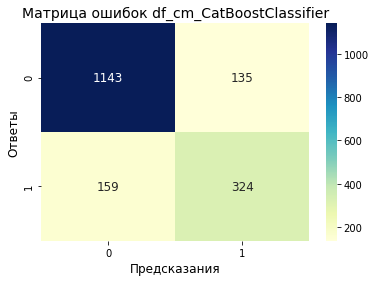

In [41]:
sns.heatmap(df_cm_CatBoostClassifier, annot=True, cmap='YlGnBu', fmt='d', annot_kws={'fontsize':12})
plt.title('Матрица ошибок ' + "df_cm_CatBoostClassifier", fontsize=14)
plt.xlabel('Предсказания', fontsize=12)
plt.ylabel('Ответы', fontsize=12)
plt.show()

На матрице ошибок видно, что модель уходит в True Negative, а значит, не упускает уходящих клиентов;

**Вывод**

Собрали исходные данные, исправили пропуски и ошибки, добавили информацию о количестве дней использования услугами.

Мы обнаружили, что доля отказов при оплате помесячно примерно равна, а при оплате за год или два минимальна. Также установили, что отказы связаны с использованием услуг менее двух месяцев и что компания может предложить стимулы для удержания клиентов в течение трех и более месяцев.

Суммарные затраты клиента влияют на вероятность оттока, поэтому важно удерживать клиентов с самого начала. Дополнительные услуги оказывают малое влияние на вероятность оттока, но они могут повлиять на суммарные затраты, поэтому следует принимать их во внимание.

Мы подготовили данные для моделей, используя наиболее значимые признаки. Мы применили масштабирование для числовых признаков, OneHotEncoder для категориальных признаков и сбалансировали целевой признак при обучении моделей.

Итогом проекта стала модель градиентного бустинга CatBoost c гиперпараметрами:
'border_count': 128,
'depth': 10,
'iterations': 500,
'learning_rate': 0.1 обученная на GPU.
Данная модель показала показатель целевой метрики в 0.88, что отвечает условиям выполнения проекта.

**Отчет**

Операции проводимые с данными в предобработке:

- Заполнение пропусков в признаке 'InternetService' значением 'Undefined'.
- Заполнение пропусков в 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
'TechSupport', 'StreamingTV', 'StreamingMovies', 'MultipleLines' значением 'No'.
- Переименование признака 'gender' -> 'Gender'.
- Преобразование целевого признака 'Rusult' в int64.
- Создание нового признака 'UsingServiceDays' путем вычетания из даты окончания обслуживания/даты выгрузки даты начала обслуживания. Последующая трансформация признака в тип int64.
- Преобразуем TotalCharges во float, c заполнением пропусков нулями.
- Удаление BeginDate и EndDate во избежании утечек

Операции с данными перед обучением моделей:

- Проверка глобальной корреляции признаков
- Разделение данных на обучающую и тестовую выборки в соотношении 75/25
- Проверка значимости признаком с помощью catboost.get_feature_importance c последующим отбором
- Копирование выборок для отдельного обучения и поиска гиперпараметров линейных алгоритмов машинного обучения
- OneHotEncoding категориальных признаков, оставшихся после выделения значимых
- Скалирование числовых признаков для линейной модели

Итоговый список признаков - ['Type','PaperlessBilling','PaymentMethod','MonthlyCharges','TotalCharges','SeniorCitizen','InternetService','OnlineSecurity','TechSupport','StreamingTV','StreamingMovies','MultipleLines','UsingServiceDays'].

Целевой признак - Result

Итоговая модель CatBoostClassifier со следующими гиперпараметрами: loss_function='Logloss', auto_class_weights = 'Balanced', depth=10, eval_metric='AUC', iterations=500, learning_rate=0.1, thread_count=-1, border_count=128, verbose=0.  

Данная модель показала показатель целевой метрики в 0.88, что отвечает условиям выполнения проекта.

Ранее намеченный план действий себя оправдал. 
Ключевыми я считаю этап предобработки данных и этап финальной подготовки данных для обучения моделей. Два данных этапа потребовали наибольшее количество трудозатрат.